# China v. USA: A Comparison

For this notebook I will be exploring various different data points collected on China and the USA by reputable sources and comparing the growth of each country.

The data used in this notebook is sourced form the [World Bank World Development Index](https://datacatalog.worldbank.org/dataset/world-development-indicators) data set.

## Initialisation

In [1]:
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

Now we load and visually inspect the data.

In [22]:
data = pd.read_csv('data/raw/WDI_csv/WDIData.csv')

print(data.describe())

               1960          1961          1962          1963          1964  \
count  3.755500e+04  4.135200e+04  4.352600e+04  4.340900e+04  4.393700e+04   
mean   2.367792e+11  2.320221e+11  2.333638e+11  2.405601e+11  2.564501e+11   
std    9.966469e+12  1.040162e+13  1.081217e+13  1.133253e+13  1.220097e+13   
min   -3.344191e+14 -3.823000e+14 -4.327955e+14 -4.769875e+14 -5.339358e+14   
25%    4.333353e+00  4.661905e+00  4.574441e+00  4.792615e+00  4.864613e+00   
50%    3.528000e+01  3.671474e+01  3.562203e+01  3.517800e+01  3.626101e+01   
75%    1.800000e+05  1.766810e+05  1.112430e+05  1.501830e+05  1.819330e+05   
max    8.353728e+14  9.312536e+14  1.011252e+15  1.084815e+15  1.184553e+15   

               1965          1966          1967          1968          1969  \
count  4.636400e+04  4.615400e+04  4.791800e+04  4.748000e+04  4.918500e+04   
mean   2.732894e+11  2.944340e+11  3.087088e+11  3.580964e+11  3.849876e+11   
std    1.350193e+13  1.488447e+13  1.621793e+13  1.

The first thing I notice here is the structure of the data. Each row appears to be a data point for a given indicator and country. The columns consist of relevant information such as the idicator code followe by one column for each year. This is not the format that pandas supports so we must restruture the data first before we can analse and plot it.

Also, the value of the `Country Name` field in the first rows is `Arab World`. Clearly this is not a country name and suggests the data is using some other classification groups.

In [3]:
print(data['Country Name'].unique())

['Arab World' 'Caribbean small states' 'Central Europe and the Baltics'
 'Early-demographic dividend' 'East Asia & Pacific'
 'East Asia & Pacific (excluding high income)'
 'East Asia & Pacific (IDA & IBRD countries)' 'Euro area'
 'Europe & Central Asia' 'Europe & Central Asia (excluding high income)'
 'Europe & Central Asia (IDA & IBRD countries)' 'European Union'
 'Fragile and conflict affected situations'
 'Heavily indebted poor countries (HIPC)' 'High income' 'IBRD only'
 'IDA & IBRD total' 'IDA blend' 'IDA only' 'IDA total'
 'Late-demographic dividend' 'Latin America & Caribbean'
 'Latin America & Caribbean (excluding high income)'
 'Latin America & the Caribbean (IDA & IBRD countries)'
 'Least developed countries: UN classification' 'Low & middle income'
 'Low income' 'Lower middle income' 'Middle East & North Africa'
 'Middle East & North Africa (excluding high income)'
 'Middle East & North Africa (IDA & IBRD countries)' 'Middle income'
 'North America' 'Not classified' 'OECD me

In [4]:
all_countries = data['Country Name'].unique()[47:]
countries_data = data.loc[data['Country Name'].isin(all_countries)]

countries_data

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
67163,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.233000e+01,2.408000e+01,2.617000e+01,2.799000e+01,3.010000e+01,3.244000e+01,NaN,NaN,NaN,NaN
67164,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.322202e+01,6.910000e+01,7.015348e+01,8.950000e+01,7.150000e+01,9.770000e+01,9.770000e+01,NaN,NaN,NaN
67165,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.957288e+01,6.084916e+01,6.287569e+01,8.650051e+01,6.457335e+01,9.709936e+01,9.709197e+01,NaN,NaN,NaN
67166,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,8.656778e+01,9.500000e+01,9.273573e+01,9.870000e+01,9.250000e+01,9.950000e+01,9.950000e+01,NaN,NaN,NaN
67167,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,9.005013e+00,NaN,NaN,9.961000e+00,NaN,NaN,1.489331e+01,NaN,NaN,NaN
67168,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.616230e+00,NaN,NaN,3.812426e+00,NaN,NaN,7.160685e+00,NaN,NaN,NaN
67169,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.541546e+01,NaN,NaN,1.578467e+01,NaN,NaN,2.253650e+01,NaN,NaN,NaN
67170,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.OL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.053888e+01,NaN,NaN,1.150844e+01,NaN,NaN,1.801650e+01,NaN,NaN,NaN
67171,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.40.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.125380e+00,NaN,NaN,6.070460e+00,NaN,NaN,1.380250e+01,NaN,NaN,NaN
67172,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.PL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,5.317275e+00,NaN,NaN,4.828490e+00,NaN,NaN,8.887749e+00,NaN,NaN,NaN


## Setup

In [5]:
COLOR_DICT = {
    'China': '#ff0000',
    'United States': '#0000ff',
    'United Kingdom': '#00df00',
    'Germany': '#ffaa00',
    'France': '#ff33cc',
    'Italy': '#009933',
    'Japan': '#00ffff'
}

# reshape data to have years as rows and countries as columns within a specified range
def get_reshaped_dataframe(indicator_code, countries=None, years=None):    
    if countries is None:
        countries = ["CHN", "USA"]
    
    if years is None:
        years = list(map(lambda x: str(x), range(1960, 2019 + 1)))

    dataframes = {}
    
    # get rows for each country
    for country in countries:
        row = countries_data.loc[(data['Country Code'] == country) & (countries_data['Indicator Code'] == indicator_code)]
        dataframes[row['Country Name'].iloc[0]] = row
    
    # concat each row into single data frame
    joined_df = pd.concat(dataframes, ignore_index=True).set_index('Country Name')
    joined_df.index.name = None
    
    indicator_name = joined_df['Indicator Name'].iloc[0]
    joined_df = joined_df[years].transpose()
    joined_df = joined_df.set_index(pd.to_datetime(joined_df.index))
    
    return (indicator_name, joined_df)

# plot the specified indicator on a graph
def plot_indicator_line(indicator_code, countries=None, years=None):
    (y_label, df) = get_reshaped_dataframe(indicator_code, countries, years)
    
    df.plot.line(figsize=(10,5), color=[COLOR_DICT.get(x, '#333333') for x in df.columns])
    
    ax = plt.gca()
    ax.set(xlabel='Year', ylabel=y_label)
    ax.grid(color='grey', linestyle='--', linewidth=0.5, axis='y')
    formatter = EngFormatter()
    ax.yaxis.set_major_formatter(formatter)
    
    plt.margins(x=0.02)
    plt.show()

# plot the % change of an indicator on a graph
def plot_indicator_change(indicator_code, countries=None, years=None, use_percentage=True):
    (y_label, df) = get_reshaped_dataframe(indicator_code, countries, years)
    
    if use_percentage:
        df = df.pct_change(axis=0).drop(df.index[0])
    
    df.plot.line(figsize=(10,5), color=[COLOR_DICT.get(x, '#333333') for x in df.columns])
    
    ax = plt.gca()
    ax.set(xlabel='Year', ylabel=y_label)
    ax.grid(color='grey', linestyle='--', linewidth=0.5, axis='y')
    formatter = EngFormatter()
    ax.yaxis.set_major_formatter(formatter)
    
    plt.margins(x=0.02)
    plt.show()

# return the % change of an indicator in table format
def table_indicator_change(indicator_code, countries=None, years=None, use_percentage=True):
    if years is None:
        years = list(map(lambda x: str(x), range(1960, 2019 + 1)))
    
    (y_label, df) = get_reshaped_dataframe(indicator_code, countries=countries, years=years)
    
    df.index = df.index.strftime('%Y')

    if use_percentage:
        df = df.pct_change(axis=0).drop(df.index[0])

    min_val = df.dropna().min().min()
    max_val = df.dropna().max().max()
    abs_max = max(abs(min_val), abs(max_val))

    cmap = LinearSegmentedColormap.from_list(name='red_to_green', colors=['red','white','green'])
    df = df.style.apply(background_gradient, cmap=cmap, m=-abs_max, M=abs_max)

    return df

# apply given background color map to table
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

# plot 2 indicators simultaneously with 2 y-axes
def plot_indicator_comparison(indicator_code_1, indicator_code_2, country=None, years=None):
    (y_label_1, df_1) = get_reshaped_dataframe(indicator_code_1, countries=[country], years=years)
    (y_label_2, df_2) = get_reshaped_dataframe(indicator_code_2, countries=[country], years=years)
    
    country_name = df_1.columns[0]
    
    df_1 = df_1.rename(columns={df_1.columns[0]: y_label_1})
    df_2 = df_2.rename(columns={df_2.columns[0]: y_label_2})
    
    ax1 = df_1.plot.line(figsize=(10,5), color='orange')
    ax2 = df_2.plot.line(figsize=(10,5), color='green', secondary_y=True, ax=ax1)
    
    ax1.grid(color='sandybrown', linestyle='--', linewidth=0.5, axis='y')
    ax2.grid(color='palegreen', linestyle='--', linewidth=0.5, axis='y')

    ax1.set_xlabel('Year')
    ax1.set_title(country_name)
    ax1.set_ylabel(y_label_1)
    ax2.set_ylabel(y_label_2)
    
    formatter = EngFormatter()
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)

# return the top n values for a given indicator and year
def indicator_top_values(indicator_code, n=5, year="2018"):
    df = countries_data.loc[countries_data['Indicator Code'] == indicator_code]
    
    top_n = df.sort_values(by=year, ascending=False).head(n)
    top_n.index = top_n[year].rank(method='first', ascending=False).astype(int)
    top_n.index.name = None
    top_n[year] = top_n.apply(lambda x: "{:,.0f}".format(x[year]), axis=1)
    
    return top_n[['Country Name', 'Indicator Name', year]]

## Economy

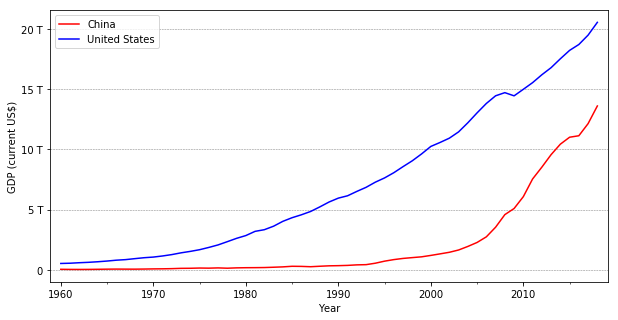

In [6]:
plot_indicator_line("NY.GDP.MKTP.CD")

Above we see the GDP for the US is greater than China's and has been since data was first recorded.

We also see that just before 2010 the US saw a contraction in its GDP per capita. This is likely due to the sub-prime mortgage crisis which occured in 2008 and plunged many of the worlds nations into recession. Interestingly, we notice that China saw very little disruption to its GDP during this period.

To investigate this further, we plot the GDP per capita (to ensure similar scales) for both China and the US along with various other developed coutries. The G7 is a group of 7 of the largest advanced economies in the world which represents 58% of the global net wealth (note: the G7 includes the US). Plotting each G7 country with the US and China we see all countries aside from China saw some sort of ecomonic contraction around the period of 2008-2009 when the crisis was at its peak.

This suggests China is somewhat economically independent of the US and the rest of the world.

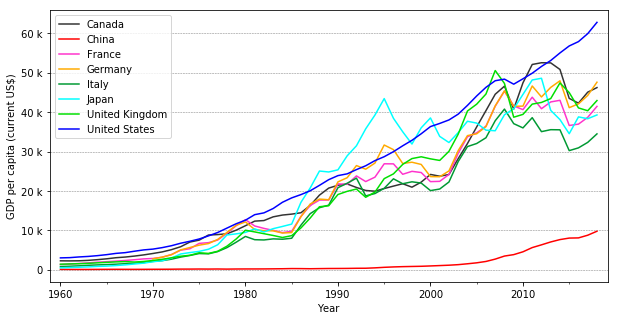

In [7]:
g7_and_china = ["CHN", "USA", "GBR", "DEU", "CAN", "FRA", "JPN", "ITA"]

plot_indicator_line("NY.GDP.PCAP.CD", countries=g7_and_china)

To determine the extent of the economic slow-downs we look at the percentage change in GDP for each of the above countries. The period we choose is from 1995 to the current day. This was chosen because it includes various economic downturns including the 2008 sub-prime mortgage crisis, the 2000 dot-com bubble, the 1997 Asian economic downturn leading to a global 'mini crash', and the recovery periods for each.

In [8]:
# 1995-2018
gdp_diff_years = list(map(lambda x: str(x), range(1994, 2018 + 1)))

table_indicator_change("NY.GDP.MKTP.CD", countries=g7_and_china, years=gdp_diff_years)

,Canada,China,France,Germany,Italy,Japan,United Kingdom,United States
1995,0.0447857,0.301641,0.148576,0.172655,0.0686356,0.110469,0.176323,0.048374
1996,0.0405852,0.175889,0.00286075,-0.0342439,0.11728,-0.112936,0.0549906,0.0567261
1997,0.0386249,0.113294,-0.0951563,-0.114228,-0.053753,-0.0866787,0.101543,0.0624829
1998,-0.0321842,0.0701319,0.0345683,0.0122067,0.0226857,-0.086579,0.0584281,0.0565737
1999,0.0700693,0.0631209,-0.0069597,-0.020003,-0.0141953,0.131325,0.0195295,0.0626567
2000,0.0979338,0.107267,-0.0873606,-0.114419,-0.0864152,0.0713361,-0.0146117,0.0645523
2001,-0.00796946,0.105708,0.010436,0.000495073,0.0202678,-0.119483,-0.0105986,0.0321366
2002,0.0292932,0.0979205,0.085597,0.0640483,0.0888589,-0.0437844,0.0879306,0.0335101
2003,0.177362,0.129025,0.231679,0.206661,0.23879,0.0803238,0.15049,0.0477144
2004,0.14659,0.177716,0.14956,0.125418,0.145527,0.0831127,0.177257,0.0659338


The most obvious observation from this table is the relentless growth of China's economy. From 1995 to the current time there has been a constant economic expansion with 3 separate years seeing approximately 30% growth in GDP. The US also saw a period of almost continuos expansion during this period but to a lesser lagnitude than China.

## Military expenditure

In [9]:
indicator_top_values("MS.MIL.XPND.CD", n=10)

,Country Name,Indicator Name,2018
1,United States,Military expenditure (current USD),"648,798,273,000"
2,China,Military expenditure (current USD),"249,996,900,635"
3,Saudi Arabia,Military expenditure (current USD),"67,554,666,667"
4,India,Military expenditure (current USD),"66,510,289,108"
5,France,Military expenditure (current USD),"63,799,676,593"
6,Russian Federation,Military expenditure (current USD),"61,387,546,980"
7,United Kingdom,Military expenditure (current USD),"49,997,192,521"
8,Germany,Military expenditure (current USD),"49,470,627,811"
9,Japan,Military expenditure (current USD),"46,617,954,864"
10,"Korea, Rep.",Military expenditure (current USD),"43,069,973,343"


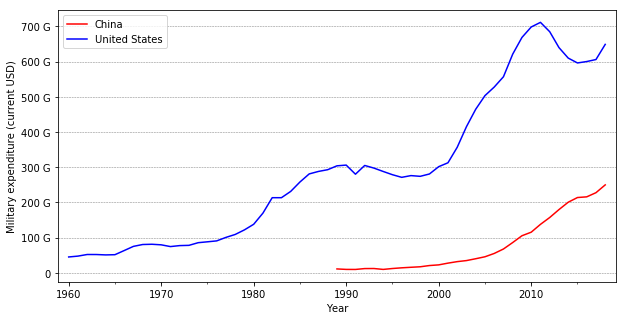

In [10]:
plot_indicator_line("MS.MIL.XPND.CD")

We choose a period of 1989-2018 to compare data points for the US and China. Before that time China has published any official figures on its total military expenditure.

For the period of 1989-2018 military expenditure was considerably higher for the US with two significant peaks. The first peak, starting around 1970, can likely be attributed to the cold war and the escalating tensions between the US and Soviet Union. This was de-escalated when the Soviet Union was dissolved in 1991, resulting in a reduction in military spending. The second peak can be attributed to the US "War on Terror" -- which included the invasion of Iraq and Afghanistan -- following the 9/11 attacks in 2001. This war would become the longest and 2nd most expensive war in US history.

In [11]:
# the only years with data available for China
mil_exp_years = list(map(lambda x: str(x), range(1989, 2018 + 1)))

table_indicator_change("MS.MIL.XPND.CD", years=mil_exp_years)

,China,United States
1990,-0.115612,0.00685664
1991,-0.0130331,-0.0845217
1992,0.247815,0.088654
1993,0.0126297,-0.0245919
1994,-0.200886,-0.0321801
1995,0.254278,-0.0319483
1996,0.155242,-0.0266769
1997,0.105861,0.0180829
1998,0.0883628,-0.00740794
1999,0.199644,0.024395


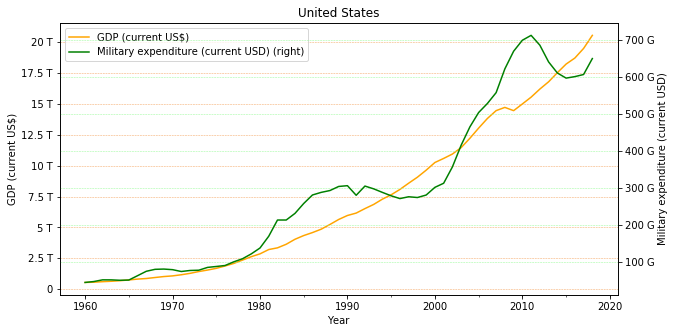

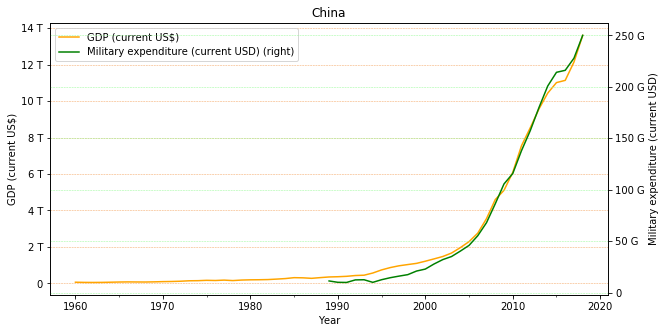

In [12]:
plot_indicator_comparison("NY.GDP.MKTP.CD", "MS.MIL.XPND.CD", country="USA")
plot_indicator_comparison("NY.GDP.MKTP.CD", "MS.MIL.XPND.CD", country="CHN")

A further interesting comparison we can make is between GDP and military expenditure. The US saw two significant surges in military spending, as mentioned earlier, due to the Cold War and the War on Terror. The act of war (or the threat of its impending arrival) is expensive and requires large increases in spending 

Looking at China was can see military expenditure is very closely correlated with GDP. China has experienced conflicts in this time but not on the scale of the US wars. This suggests that China is experiencing more of a 'natural' growth of its military, motivated by its growing international economic and political influence. Having said that, this does not exclude the possibility of war as a motivator for China. The US and China are very different both in terms of ideology and their strategic goals around the world.

## Health

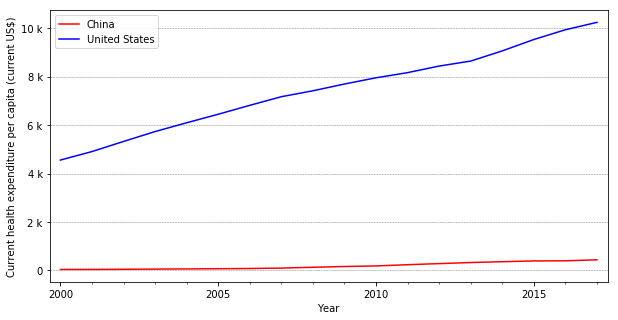

In [13]:
plot_indicator_line("SH.XPD.CHEX.PC.CD")

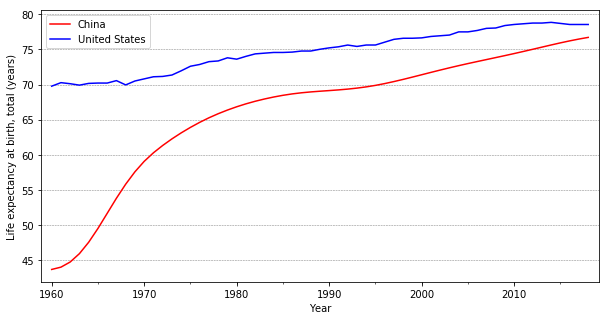

In [20]:
plot_indicator_line("SP.DYN.LE00.IN")

## Environment

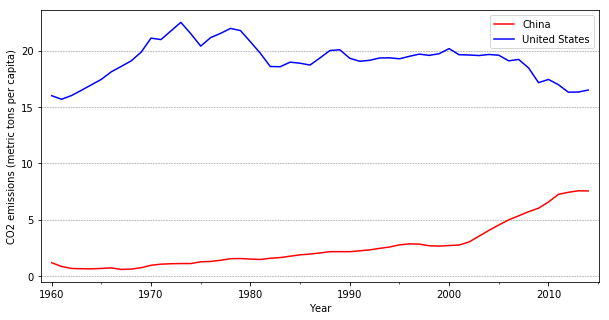

In [15]:
plot_indicator_line("EN.ATM.CO2E.PC")

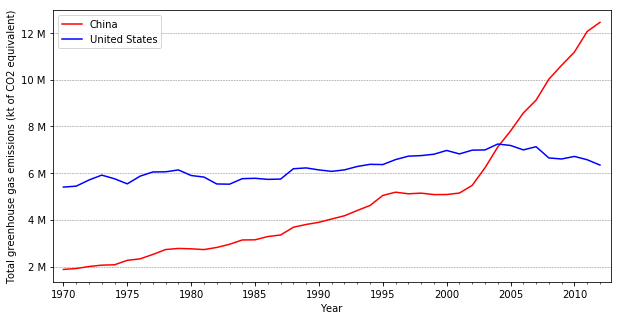

In [16]:
plot_indicator_line("EN.ATM.GHGT.KT.CE")

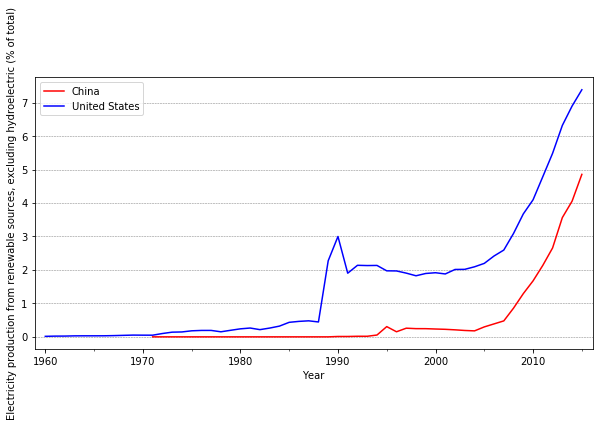

In [17]:
plot_indicator_line("EG.ELC.RNWX.ZS")

## Transport

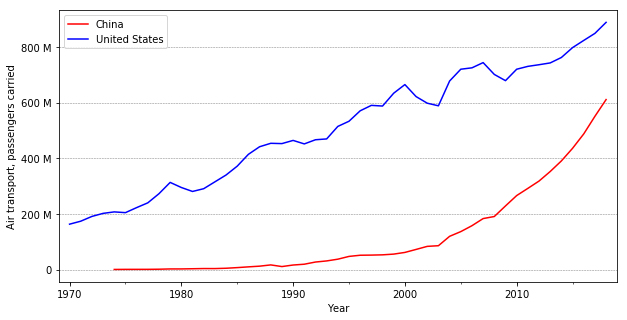

In [18]:
plot_indicator_line("IS.AIR.PSGR")

## Conclusion

### Evaluation of Method

- could have improved speed by only fetching certain indicators/countries but for the purposed of this dynamic exploratory report current soluton is OK.